## City Sector Clustering
#### The intention is to use unsupervised learning in order to cluster city sectors based on the area they cover. The type of area that is covered is as follows:
— <span style="color:green">Residential

— <span style="color:aqua">Semi-Residential

— <span style="color:orange">Semi-Commercial

— <span style="color:red">Commercial

#### After that LTE UE Power Headroom Restriction measurements for different frequency bands will be used to analyze the area with poor indoor coverage.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import *
import math
from sklearn.cluster import KMeans
import plotly.express as px
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
sector_df = pd.read_excel("Tehran_Sectors.xlsx")
sector_df.head(3)

,Sector_ID,Vendor,Lat,Long,Azimuth,Hour,Working Hour,Residential Factor,Commercial Factor,PHR_1L1_Daily,PHR_1L2_Daily,PHR_2L_Daily,PHR_3L_Daily
0,TH0001A,ERICSSON,35.67435,51.4813,80,22,15.222298,1.486298,0.904671,49.960,36.213,29.820,21.163
1,TH0001B,ERICSSON,35.67435,51.4813,175,22,15.586067,1.425461,0.949236,25.909,16.497,31.414,13.519
2,TH0001C,ERICSSON,35.67435,51.4813,340,22,15.594077,1.473569,1.048980,49.148,39.986,46.112,54.186


### Functions for creating sectors

In [3]:
def degree2rad(degrees):
    return degrees * pi / 180


def sec_poly(long, lat, bearing, radius=0.5, vbw=60):
    R = 6378.1  # Radius of the Earth
    rad_bearing = degree2rad(bearing)

    site_lat = math.radians(lat)  # site lat point converted to radians
    site_lon = math.radians(long)  # site long point converted to radians

    coords = []
    n = 5
    t = np.linspace(degree2rad(bearing - (vbw / 2)), degree2rad(bearing + (vbw / 2)), n)
    for brg in t:
        bor_lat = math.asin(math.sin(site_lat) * math.cos(radius / R) + math.cos(site_lat) * math.sin(radius / R) * math.cos(brg))
        bor_lon = site_lon + math.atan2(math.sin(brg) * math.sin(radius / R) * math.cos(site_lat),
                                    math.cos(radius / R) - math.sin(site_lat) * math.sin(bor_lat))

        bor_lat = math.degrees(bor_lat)
        bor_lon = math.degrees(bor_lon)

        coords.append([bor_lon, bor_lat])

    coords.insert(0, [long, lat])
    coords.append([long, lat])

    return (coords)

### Creating sector polygons for all sectors in the file in GeoJSON format

In [4]:
radius = 0.3
vbw = 60
GeoJSON_list = []

for i in range(0,len(sector_df)):
    poly_sec_list = sec_poly(sector_df['Long'][i], sector_df['Lat'][i], sector_df['Azimuth'][i], radius * sector_df['PHR_1L1_Daily'][i] / 100 , vbw)
    GeoJSON_list.append(dict(type= 'Feature',
                properties= dict(Sector_ID=sector_df['Sector_ID'][i],
                                ),
                geometry= dict(type= 'Polygon',
                               coordinates= [poly_sec_list]
                              ),
                Sector_ID= sector_df['Sector_ID'][i]
               )            
    )

In [5]:
GeoJSON_dict = {'type': 'FeatureCollection', 'features': GeoJSON_list}

### Ploting sectors on map

In [ ]:
fig = px.choropleth_mapbox(sector_df, geojson=GeoJSON_dict,
                           locations=sector_df['Sector_ID'], featureidkey="properties.Sector_ID",
                           center={"lat": 35.67435, "lon": 51.4813},
                           mapbox_style="carto-positron", zoom=10)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

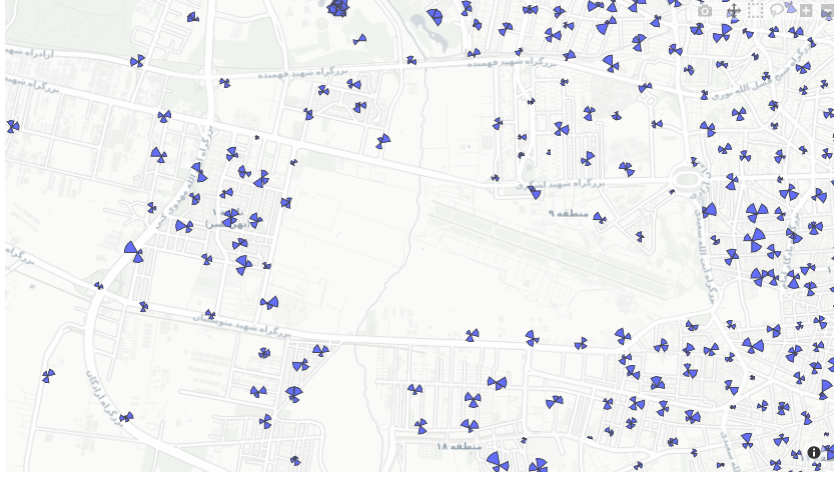

### Feature Description
- Working Hour: (Average Connected User / Peak Connected User) * 24
- Residential Factor: Connected User for 23:00 / Average Connected User
- Commercial Factor: Connected User for 13:00 / Average Connected User
- UE Power Restriction: (number of samples for UE's using max power / total sample) * 100
- 1L1: L2600 1st carrier / 1L2: L2600 2nd carrier / 2L: L1800 carrier / 3L: L2100 carrier

In [7]:
# making a feature list
features = [
    f for f in sector_df.columns if f not in ('Sector_ID', 'Lat', 'Long', 'Azimuth', 
                                              'PHR_1L1_Daily', 'PHR_1L2_Daily', 'PHR_2L_Daily', 'PHR_3L_Daily', 'Vendor')]

cluster_df = sector_df[features]
features

['Hour', 'Working Hour', 'Residential Factor', 'Commercial Factor']

In [8]:
# Feature Scalling
from sklearn import preprocessing

Scalling = 'standard' # 'none', 'normal', 'standard'

if Scalling == 'standard':
    scalled_cluster_ar = preprocessing.StandardScaler().fit_transform(cluster_df)
    
elif Scalling == 'normal':
    scalled_cluster_ar = preprocessing.MinMaxScaler().fit_transform(cluster_df)
    
elif Scalling == 'none':
    scalled_cluster_ar = cluster_df

print(scalled_cluster_ar.min())
print(scalled_cluster_ar.max())

-6.521897000062924
14.25224696940121


### Defining the number of clusters using elbow method

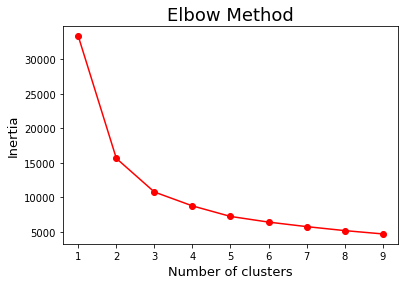

In [9]:
# Elbow method for optimal value of k in KMeans
inertia_list = []
for k in np.arange(1, 10):
    kmn = KMeans(n_clusters=k)
    kmn.fit(scalled_cluster_ar)
    inertia_list.append(kmn.inertia_)
    
plt.plot(np.arange(1,10),inertia_list,'ro-')
plt.title('Elbow Method', fontsize=18)
plt.xlabel('Number of clusters', fontsize=13)
plt.ylabel('Inertia', fontsize=13)
plt.show()

### Sector Clustering

In [10]:
kmn = KMeans(n_clusters=4, random_state=4)
kmn.fit(scalled_cluster_ar)

KMeans(n_clusters=4, random_state=4)

In [11]:
# Appending labels to sector_df

sector_df['Label'] = kmn.labels_

Color_Label = {0: "aqua", 1: "red", 2: "orange", 3: "green"}
sector_df['Color'] = sector_df['Label'].map(Color_Label)

Type_Label = {0: "Semi-Residential", 1: "Commercial", 2: "Semi-Commercial", 3: "Residential"}
sector_df['Type'] = sector_df['Label'].map(Type_Label)

sector_df.head(3)

,Sector_ID,Vendor,Lat,Long,Azimuth,Hour,Working Hour,Residential Factor,Commercial Factor,PHR_1L1_Daily,PHR_1L2_Daily,PHR_2L_Daily,PHR_3L_Daily,Label,Color,Type
0,TH0001A,ERICSSON,35.67435,51.4813,80,22,15.222298,1.486298,0.904671,49.960,36.213,29.820,21.163,3,green,Residential
1,TH0001B,ERICSSON,35.67435,51.4813,175,22,15.586067,1.425461,0.949236,25.909,16.497,31.414,13.519,3,green,Residential
2,TH0001C,ERICSSON,35.67435,51.4813,340,22,15.594077,1.473569,1.048980,49.148,39.986,46.112,54.186,3,green,Residential


In [12]:
sector_df[['Type', 'Hour', 'Working Hour', 'Residential Factor', 'Commercial Factor']].groupby(by=['Type']).mean().round(1)

,Hour,Working Hour,Residential Factor,Commercial Factor
Type,,,,
Commercial,13.0,11.0,0.5,2.0
Residential,21.9,14.9,1.5,1.0
Semi-Commercial,13.5,15.1,0.9,1.4
Semi-Residential,20.2,16.8,1.2,1.1


In [13]:
sector_df[['Type', 'PHR_1L1_Daily', 'PHR_1L2_Daily', 'PHR_2L_Daily', 'PHR_3L_Daily']].groupby(by=['Type']).mean().round(1)

,PHR_1L1_Daily,PHR_1L2_Daily,PHR_2L_Daily,PHR_3L_Daily
Type,,,,
Commercial,28.9,22.5,29.0,16.8
Residential,35.5,26.5,30.9,27.2
Semi-Commercial,30.3,23.5,28.6,19.3
Semi-Residential,33.2,24.8,30.3,23.0


In [14]:
len(kmn.labels_)

8333

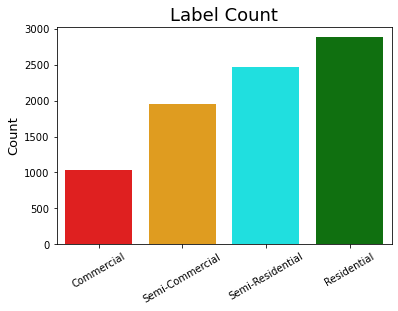

In [15]:
b = sns.countplot(x='Type', data=sector_df, palette=["red", "orange", "aqua", "green"],
                 order=["Commercial", "Semi-Commercial", "Semi-Residential", "Residential"])
b.set_title('Label Count', fontsize=18)
b.set_ylabel("Count", fontsize=13)
b.tick_params(axis='x', rotation=30)
b.set_xlabel("");

In [ ]:
cluster_fig = px.choropleth_mapbox(sector_df, geojson=GeoJSON_dict,color=sector_df.Type, 
                           color_discrete_map={"Semi-Residential":"aqua", "Commercial": "red", "Semi-Commercial":"orange", "Residential":"green"},
                           locations=sector_df['Sector_ID'], featureidkey="properties.Sector_ID",
                           center={"lat": 35.67435, "lon": 51.4813},
                           mapbox_style="carto-positron", zoom=10)
cluster_fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0},
                       legend=dict(
                           x=0,
                           y=1,
                           title="",
                           bgcolor='rgba(255, 255, 255, 0)',
                           bordercolor='rgba(255, 255, 255, 0)',
                           font=dict(color='blue'))
                 )
cluster_fig.show()

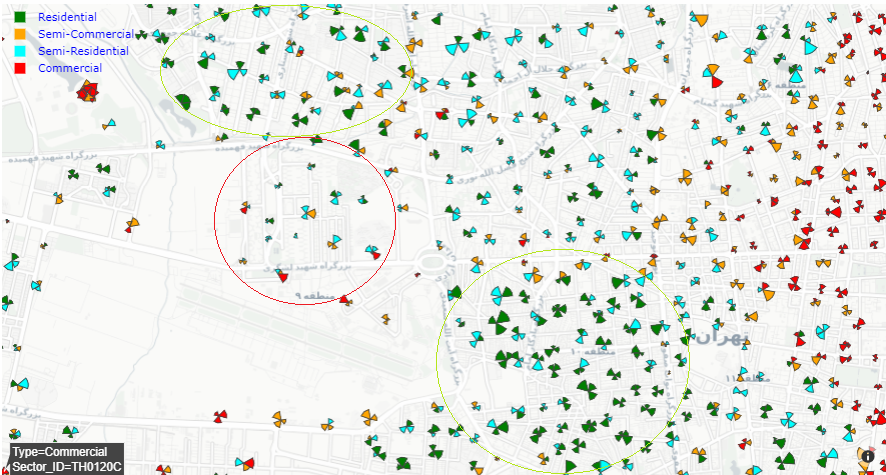

In [17]:
# Filling the list using cluster centers
centroids = kmn.cluster_centers_
print(centroids)

[[ 0.44038579  0.83459778  0.18140565 -0.30059963]
 [-1.24471464 -1.87853128 -1.82404974  1.88189326]
 [-1.13845397  0.05011527 -0.65370233  0.42312765]
 [ 0.83875109 -0.07097621  0.93818275 -0.70223546]]


In [18]:
cluster_df.columns

Index(['Hour', 'Working Hour', 'Residential Factor', 'Commercial Factor'], dtype='object')

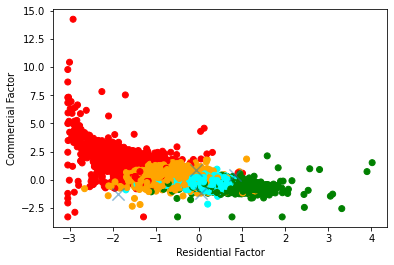

In [19]:
#plt.rcParams["figure.figsize"] = (14,8)

ys = scalled_cluster_ar[:,3] # Commercial Factor
xs = scalled_cluster_ar[:,2] # Residential Factor
zs = scalled_cluster_ar[:,1] # Working Hour

plt.xlabel(cluster_df.columns[2])
plt.ylabel(cluster_df.columns[3])

centroids = kmn.cluster_centers_
plt.scatter(xs, ys, c=sector_df.Color) # assign color to each label
plt.scatter(centroids[:,1],centroids[:,0],marker='x',s=150,alpha=0.5) # Show central cluster in plot
plt.show()

In [20]:
df_3d = pd.DataFrame(scalled_cluster_ar, columns=features)
df_3d['Color'] = sector_df['Color']
df_3d

,Hour,Working Hour,Residential Factor,Commercial Factor,Color
0,0.866087,0.086732,0.869860,-0.942104,green
1,0.866087,0.256370,0.709665,-0.825609,green
2,0.866087,0.260105,0.836342,-0.564870,green
3,0.866087,0.379154,0.674631,-0.450902,green
4,0.866087,0.369128,0.715947,-0.765777,green
...,...,...,...,...,...
8328,-2.194701,-2.120008,-1.370244,0.718717,red
8329,-1.252920,-1.487139,-1.237554,1.988541,red
8330,0.866087,1.027124,0.619783,-0.593226,aqua
8331,1.101532,-0.376063,1.397266,-0.933756,green


In [21]:
# import plotly.express as px
# fig_3d = px.scatter_3d(df_3d, x='Residential Factor', y='Commercial Factor', z='Working Hour',
#               color='Color', color_discrete_map={"aqua":"aqua", "red": "red", "orange":"orange", "green":"green"})
# fig_3d.show()

In [22]:
sector_df.head(3)

,Sector_ID,Vendor,Lat,Long,Azimuth,Hour,Working Hour,Residential Factor,Commercial Factor,PHR_1L1_Daily,PHR_1L2_Daily,PHR_2L_Daily,PHR_3L_Daily,Label,Color,Type
0,TH0001A,ERICSSON,35.67435,51.4813,80,22,15.222298,1.486298,0.904671,49.960,36.213,29.820,21.163,3,green,Residential
1,TH0001B,ERICSSON,35.67435,51.4813,175,22,15.586067,1.425461,0.949236,25.909,16.497,31.414,13.519,3,green,Residential
2,TH0001C,ERICSSON,35.67435,51.4813,340,22,15.594077,1.473569,1.048980,49.148,39.986,46.112,54.186,3,green,Residential


In [23]:
sector_df.to_excel("K-Means_Clustering.xlsx", index=False)